In [1]:
import numpy as np 
import os 
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 
from mpl_toolkits.mplot3d import Axes3D 


def triangular_plot(chains,save='None',fig_size=25):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(fig_size,fig_size))
    fig.set(facecolor = "white")
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1}")
    for i in range(ndim):
        for j in range(i):
            plt.subplot(ndim,ndim,ndim*i+j+1)
            counts,xbins,ybins,image = plt.hist2d(data[:,j],data[:,i],bins=100
                                      ,norm=LogNorm()
                                      , cmap = plt.cm.rainbow)
            plt.colorbar()
            plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

def triangular_plot_slopes(chains,save='None',fig_size=25):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(fig_size,fig_size))
    fig.set(facecolor = "white")
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            #those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope0=data[:,i]/data[:,j]
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j+1}/x{i+1}")
            #ax.set_ylabel(f"x{i}")
    if save != 'None':
        plt.savefig(save,transparent=False)
        plt.show()
    else: 
        plt.show()

In [2]:
import tensorflow as tf
import time

2024-10-12 14:24:52.916352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%matplotlib widget

In [4]:
# compute (||∇V||^2)
def grad_norm_squared(V, x ,factor=1):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared * factor

def get_grad(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    return gradients

In [5]:
def VHiggs_3d(x):
    x1,x2,x3=tf.split(x, 3, axis=1)
    return x1**2*(x1**2+x2**2-1)**2
def VHiggs_3d_scrambled(x):
    x1_temp,x2_temp,x3_temp=tf.split(x, 3, axis=1)
    x1 = x1_temp+x2_temp+x3_temp
    x2 = x2_temp+x3_temp
    x3 = x1_temp-x2_temp+x3_temp
    return x1**2*(x1**2+x2**2-1)**2    

In [14]:
# randomly initialize the points
n_points = 100000
xHiggs_3d = tf.Variable(4*np.random.rand(n_points, 3)-2, dtype=tf.float32)

historyHiggs_3d = []

In [15]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = True 
for step in range(1000):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(VHiggs_3d, xHiggs_3d)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_3d])

    #if update_alpha and step % 300 == 0 and step != 0:
    #    alpha = alpha/2
    #    optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 601:
        update_opt = False 
        optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_3d]))
    
    historyHiggs_3d.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = 711828480.0 with learning rate 0.009999999776482582
Step 10: ||∇V||^2 = 369061952.0 with learning rate 0.009999999776482582
Step 20: ||∇V||^2 = 199771968.0 with learning rate 0.009999999776482582
Step 30: ||∇V||^2 = 118523152.0 with learning rate 0.009999999776482582
Step 40: ||∇V||^2 = 77698176.0 with learning rate 0.009999999776482582
Step 50: ||∇V||^2 = 55395096.0 with learning rate 0.009999999776482582
Step 60: ||∇V||^2 = 42031988.0 with learning rate 0.009999999776482582
Step 70: ||∇V||^2 = 33323594.0 with learning rate 0.009999999776482582
Step 80: ||∇V||^2 = 27247064.0 with learning rate 0.009999999776482582
Step 90: ||∇V||^2 = 22780464.0 with learning rate 0.009999999776482582
Step 100: ||∇V||^2 = 19368270.0 with learning rate 0.009999999776482582
Step 110: ||∇V||^2 = 16685847.0 with learning rate 0.009999999776482582
Step 120: ||∇V||^2 = 14530598.0 with learning rate 0.009999999776482582
Step 130: ||∇V||^2 = 12768849.0 with learn

In [16]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs_3d,xHiggs_3d)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 0
Number of points with ||∇V||^2 > 1e-09 : 1
Number of points with ||∇V||^2 > 1e-10 : 69
Number of points with ||∇V||^2 > 1e-11 : 272
Number of points with ||∇V||^2 > 1e-12 : 659
Number of points with ||∇V||^2 > 1e-13 : 2350
Number of points with ||∇V||^2 > 1e-14 : 8296


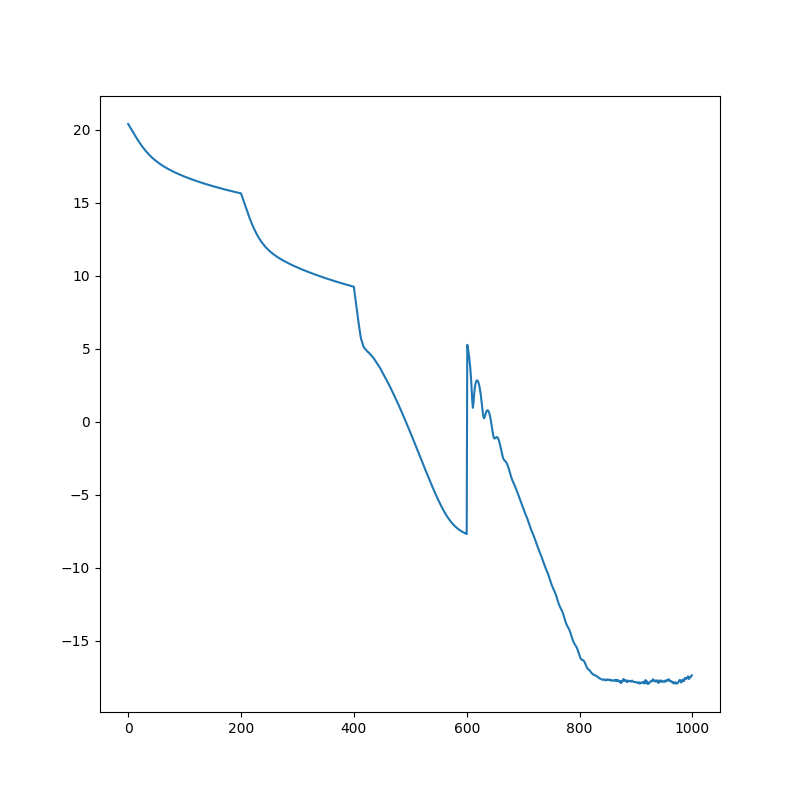

In [17]:
#all_steps = np.linspace(1,len(history),len(history))
plt.figure(figsize=(8,8))
plt.plot(np.log(historyHiggs_3d))
plt.show()

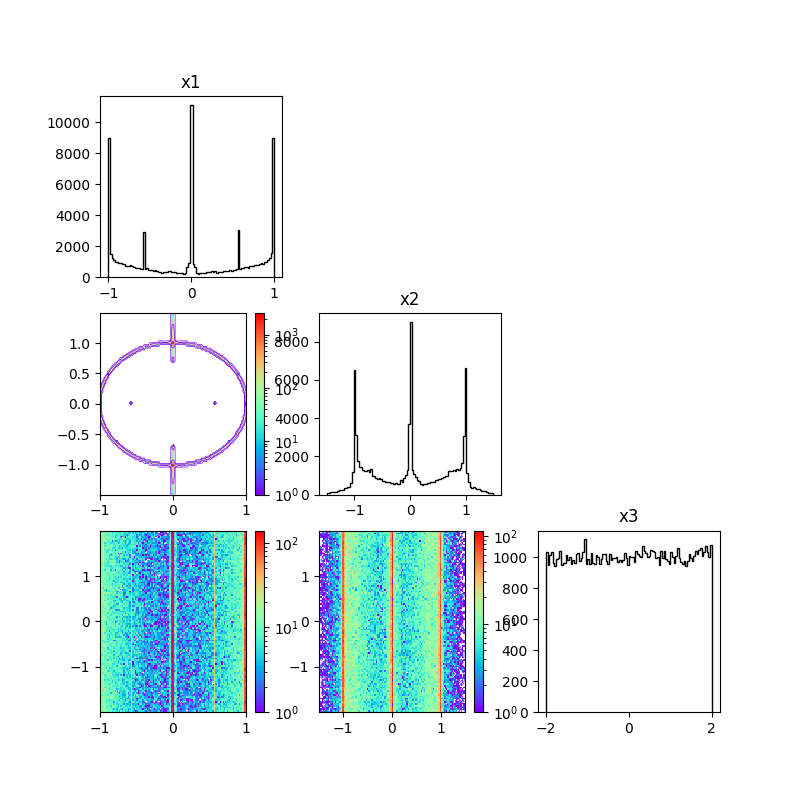

In [18]:
triangular_plot(xHiggs_3d.numpy(),fig_size=8)

In [1]:
#fig = plt.figure(figsize=(7,7))
#ax = Axes3D(fig) 
#
#ax.scatter(xHiggs_3d.numpy()[::10,0], xHiggs_3d.numpy()[::10,1], xHiggs_3d.numpy()[::10,2],color="green",s=1) 
#
#plt.show()


In [20]:
################ Auto encoder part ################
###################################################
###################################################

In [128]:
import keras
from keras import layers,models


In [2]:
#

input_dim = 6
latent_dim = 6 

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation='sigmoid')(inputs)
#encoded = layers.Dense(16, activation='sigmoid')(encoded)
#encoded = layers.Dense(16, activation='sigmoid')(encoded)
#encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
#decoded = layers.Dense(16, activation='sigmoid')(decoded)
#decoded = layers.Dense(16, activation='sigmoid')(decoded)
#decoded = layers.Dense(8, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Modèle auto-encodeur
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

NameError: name 'layers' is not defined

In [23]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train = np.array([np.extract(mask_train,xHiggs_3d.numpy()[:,i]) for i in range(3)]).T
set_test = np.array([np.extract(1-mask_train,xHiggs_3d.numpy()[:,i]) for i in range(3)]).T
print(set_train.shape)
print(set_test.shape)

(90010, 3)
(9990, 3)


In [25]:
history_autoencoder_Higgs = autoencoder.fit(set_train, set_train, epochs=100, batch_size=100, shuffle=True, validation_data=(set_test,set_test))


Epoch 1/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5562 - val_loss: 0.1086
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0380 - val_loss: 0.0065
Epoch 3/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 4/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 5/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 6/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 7/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8649e-04 - val_loss: 8.1624e-04
Epoch 9/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7700e-04 - val_loss: 6.6310e-04
Epoch 10/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.3673e-04 - val_loss: 5.4234e-04
Epoch 11/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3956e-04 - val_loss: 4.5905e-04
Epoch 12/

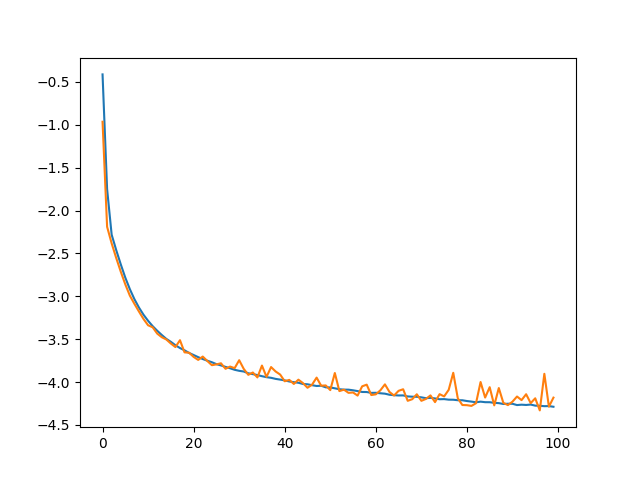

In [26]:
plt.figure()
plt.plot(np.log(history_autoencoder_Higgs.history["loss"])/np.log(10))
plt.plot(np.log(history_autoencoder_Higgs.history["val_loss"])/np.log(10))
plt.show()

In [27]:
encoder_Higgs = keras.Model(inputs, encoded)

In [28]:
encoded_points_Higgs = encoder_Higgs.predict(set_test)  
reconstructed_points = autoencoder.predict(set_test)  


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


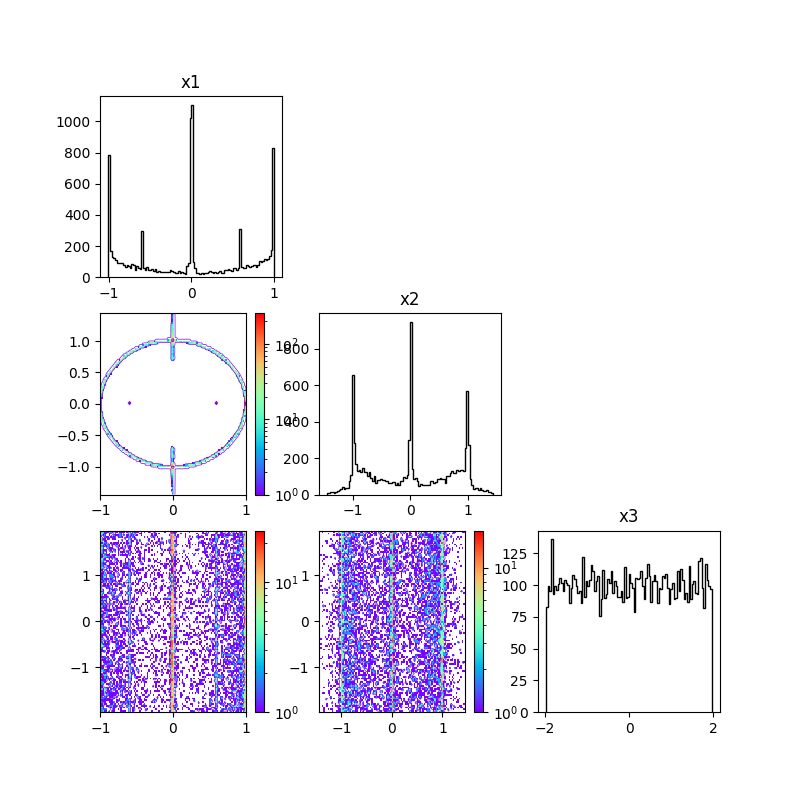

In [29]:
triangular_plot(reconstructed_points_deep,fig_size = 8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_2334/309963268.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


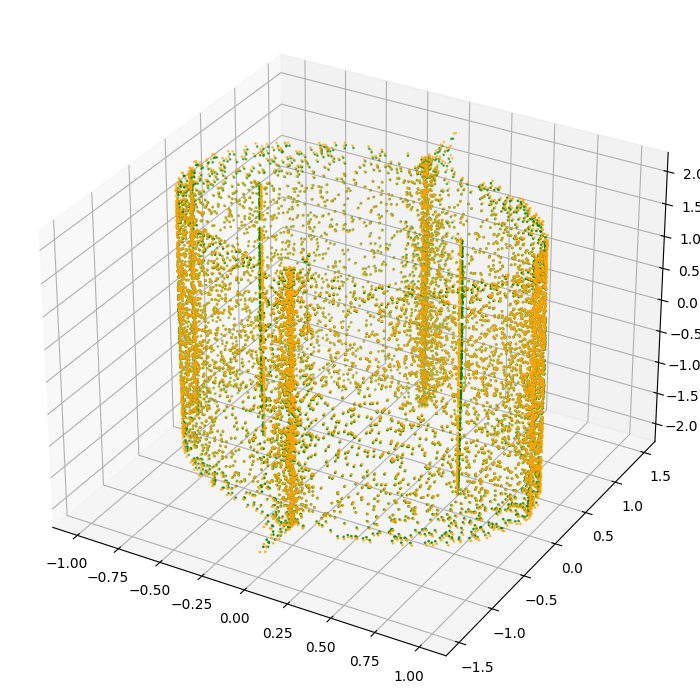

In [30]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(reconstructed_points_deep[:,0],reconstructed_points_deep[:,1],reconstructed_points_deep[:,2],color="green",s=1) 
ax.scatter(set_test[:,0],set_test[:,1],set_test[:,2],color="orange",s=1) 

plt.show()


In [115]:
#

input_dim = 3  
latent_dim = 2 

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(32, activation='sigmoid')(encoded)
#encoded = layers.Dense(32, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(32, activation='sigmoid')(encoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
#decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Modèle auto-encodeur
autoencoder_2 = keras.Model(inputs, decoded)
autoencoder_2.compile(optimizer='adam', loss='mse')

In [116]:
autoencoder_2.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501 (9.77 KB)

 Trainable params: 2,501 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
history_autoencoder_Higgs_2 = autoencoder_2.fit(set_train, set_train, epochs=200, batch_size=100, shuffle=True, validation_data=(set_test,set_test))


Epoch 1/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5645 - val_loss: 0.1606
Epoch 2/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1570 - val_loss: 0.1517
Epoch 3/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1499 - val_loss: 0.1517
Epoch 4/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1490 - val_loss: 0.1494
Epoch 5/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1480 - val_loss: 0.1497
Epoch 6/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1477 - val_loss: 0.1491
Epoch 7/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1488 - val_loss: 0.1491
Epoch 8/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1477 - val_loss: 0.1488
Epoch 9/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1488 - val_loss: 0.1530
Epoch 10/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1494 - val_loss: 0.1495
Epoch 11/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1486 - val_loss: 0.1488
Epoch 12/200
901/901 ━━━━━━━━━━━━━━━━━━━━

Epoch 135/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 136/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 137/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 138/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 139/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 140/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 141/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 142/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 143/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 144/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 145/200
901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 146/200
901/901

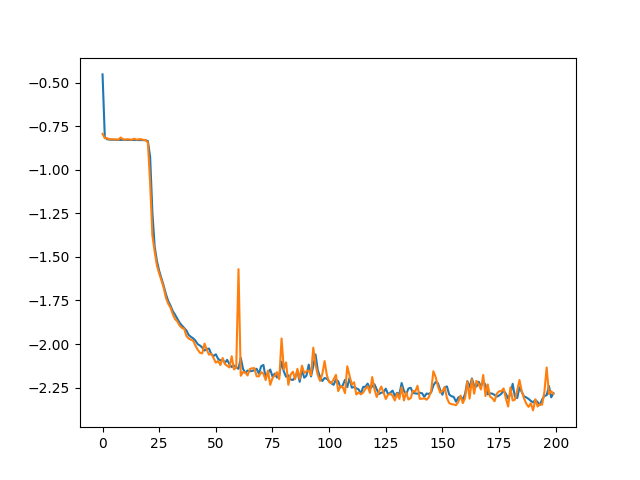

In [118]:
plt.figure()
plt.plot(np.log(history_autoencoder_Higgs_2.history["loss"])/np.log(10))
plt.plot(np.log(history_autoencoder_Higgs_2.history["val_loss"])/np.log(10))
plt.show()

In [157]:
encoder = models.Model(inputs, encoded)

latent_inputs = layers.Input(shape=(latent_dim,))  
decoded_layer = autoencoder_2.layers[-3](latent_inputs)
decoded_layer = autoencoder_2.layers[-2](decoded_layer)
decoded_output = autoencoder_2.layers[-1](decoded_layer)

decoder = models.Model(latent_inputs, decoded_output)

In [158]:
encoded_points = encoder.predict(set_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Forme des points encodés : (9990, 2)


In [159]:
decoded_points = decoder.predict(encoded_points)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Forme des points décodés : (9990, 3)


In [160]:
reconstructed_points_2 = autoencoder_2.predict(set_test)  


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


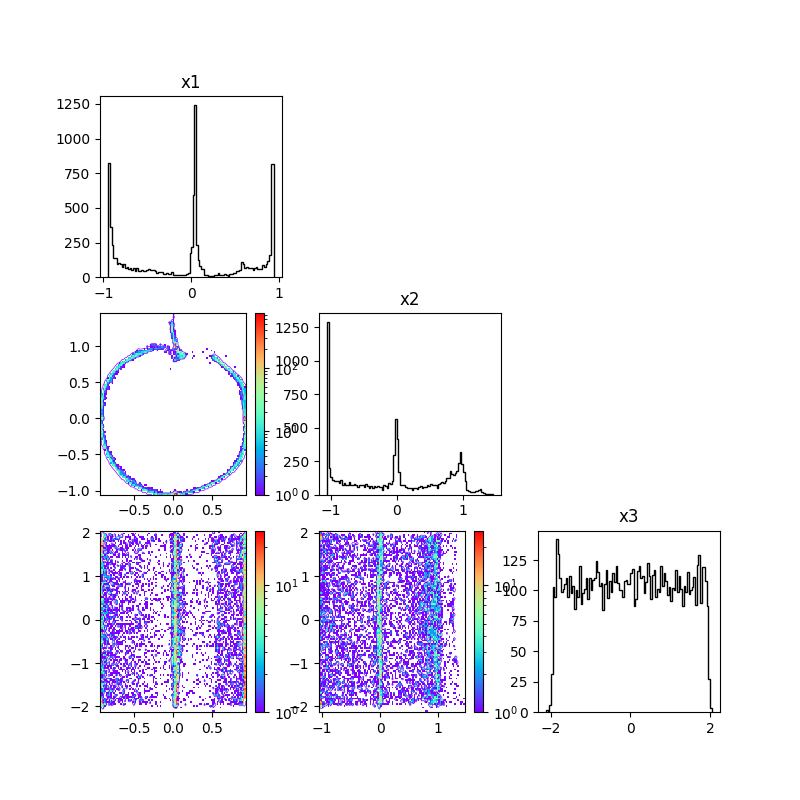

In [161]:
triangular_plot(reconstructed_points_2,fig_size = 8)


/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_2334/3881914155.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


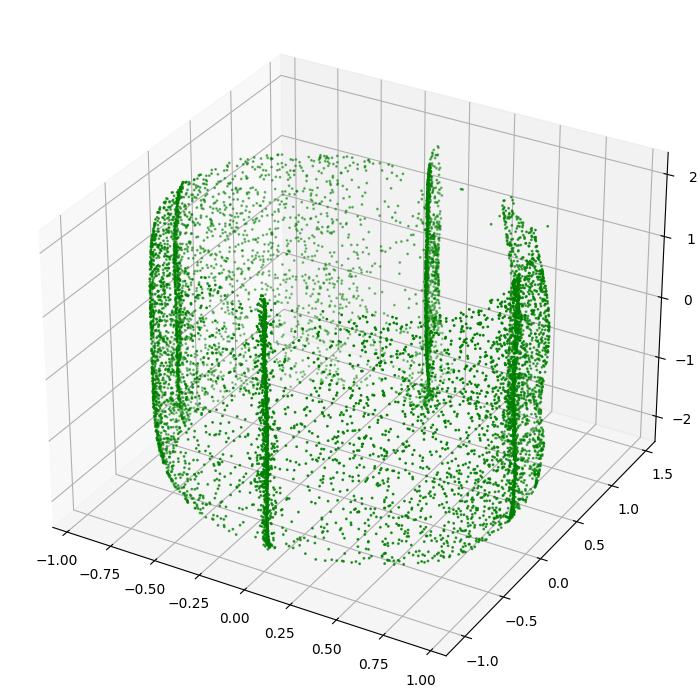

In [122]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(reconstructed_points_2[:,0],reconstructed_points_2[:,1],reconstructed_points_2[:,2],color="green",s=1) 
#ax.scatter(set_test[:,0],set_test[:,1],set_test[:,2],color="orange",s=1) 

plt.show()


In [188]:
n_points_excite = 10000
excite_y0_raw = np.linspace(-1,2,n_points_excite)
excite_y0 = np.zeros((n_points_excite,2))
excite_y0[:,0] += excite_y0_raw

excite_y1_raw = np.linspace(-1,2,n_points_excite)
excite_y1 = np.zeros((n_points_excite,2))
excite_y1[:,1] += excite_y1_raw

In [189]:
decoded_points_y0 = decoder.predict(excite_y0)
decoded_points_y1 = decoder.predict(excite_y1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


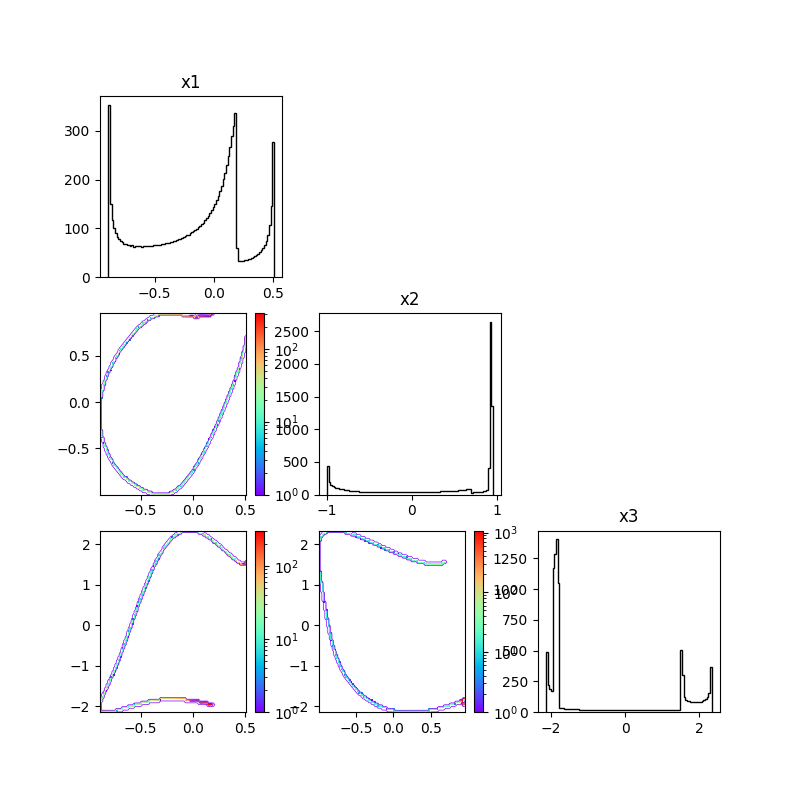

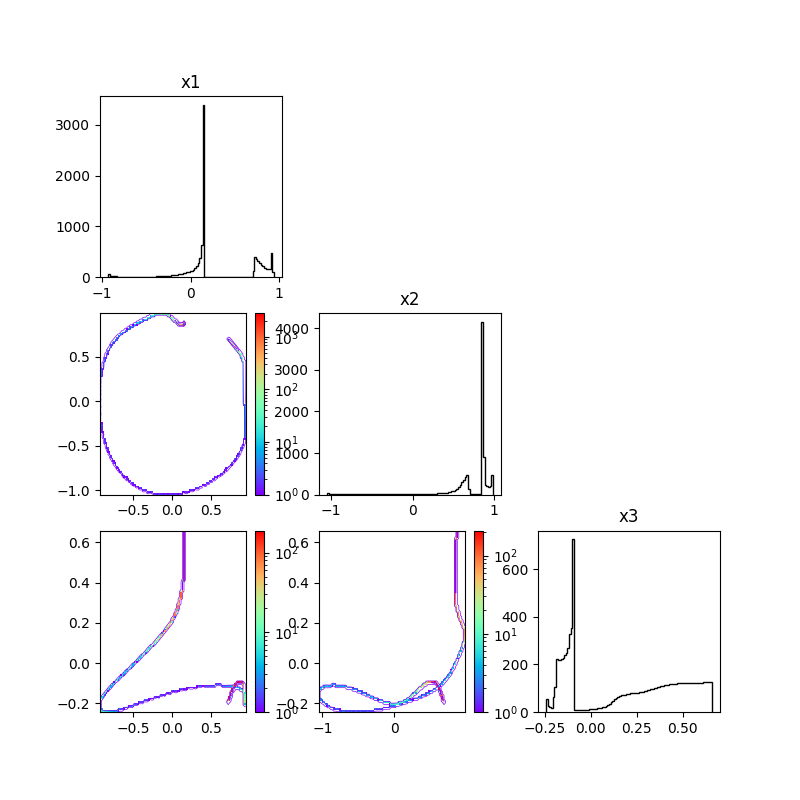

In [190]:
triangular_plot(decoded_points_y0,fig_size=8)
triangular_plot(decoded_points_y1,fig_size=8)

In [ ]:
###### Scrambled potential 

In [195]:
# randomly initialize the points
n_points = 100000
xHiggs_3d_scrambled = tf.Variable(4*np.random.rand(n_points, 3)-2, dtype=tf.float32)

historyHiggs_3d_scrambled = []

In [196]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)
alpha = init_alpha

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

#update_alpha = False
update_opt = True
for step in range(1500):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(VHiggs_3d_scrambled, xHiggs_3d_scrambled)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [xHiggs_3d_scrambled])

    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    
    if step == 1001:
        update_opt = False 
        optimizer.learning_rate.assign(0.001)
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [xHiggs_3d_scrambled]))
    
    historyHiggs_3d_scrambled.append(loss)
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-10: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = 10566382911488.0 with learning rate 0.009999999776482582
Step 10: ||∇V||^2 = 5459377389568.0 with learning rate 0.009999999776482582
Step 20: ||∇V||^2 = 2969489637376.0 with learning rate 0.009999999776482582
Step 30: ||∇V||^2 = 1779709247488.0 with learning rate 0.009999999776482582
Step 40: ||∇V||^2 = 1180348710912.0 with learning rate 0.009999999776482582
Step 50: ||∇V||^2 = 850890326016.0 with learning rate 0.009999999776482582
Step 60: ||∇V||^2 = 652025790464.0 with learning rate 0.009999999776482582
Step 70: ||∇V||^2 = 521469001728.0 with learning rate 0.009999999776482582
Step 80: ||∇V||^2 = 429742751744.0 with learning rate 0.009999999776482582
Step 90: ||∇V||^2 = 361899819008.0 with learning rate 0.009999999776482582
Step 100: ||∇V||^2 = 309781004288.0 with learning rate 0.009999999776482582
Step 110: ||∇V||^2 = 268597624832.0 with learning rate 0.009999999776482582
Step 120: ||∇V||^2 = 235348754432.0 with learning rate 0.0099999

Step 1060: ||∇V||^2 = 0.344454824924469 with learning rate 0.009999999776482582
Step 1070: ||∇V||^2 = 0.3144909143447876 with learning rate 0.009999999776482582
Step 1080: ||∇V||^2 = 0.2871292233467102 with learning rate 0.009999999776482582
Step 1090: ||∇V||^2 = 0.2621137499809265 with learning rate 0.009999999776482582
Step 1100: ||∇V||^2 = 0.23923085629940033 with learning rate 0.009999999776482582
Step 1110: ||∇V||^2 = 0.21829988062381744 with learning rate 0.009999999776482582
Step 1120: ||∇V||^2 = 0.1991654634475708 with learning rate 0.009999999776482582
Step 1130: ||∇V||^2 = 0.18169020116329193 with learning rate 0.009999999776482582
Step 1140: ||∇V||^2 = 0.16575032472610474 with learning rate 0.009999999776482582
Step 1150: ||∇V||^2 = 0.15123172104358673 with learning rate 0.009999999776482582
Step 1160: ||∇V||^2 = 0.1380273997783661 with learning rate 0.009999999776482582
Step 1170: ||∇V||^2 = 0.12605027854442596 with learning rate 0.009999999776482582
Step 1180: ||∇V||^2 = 0

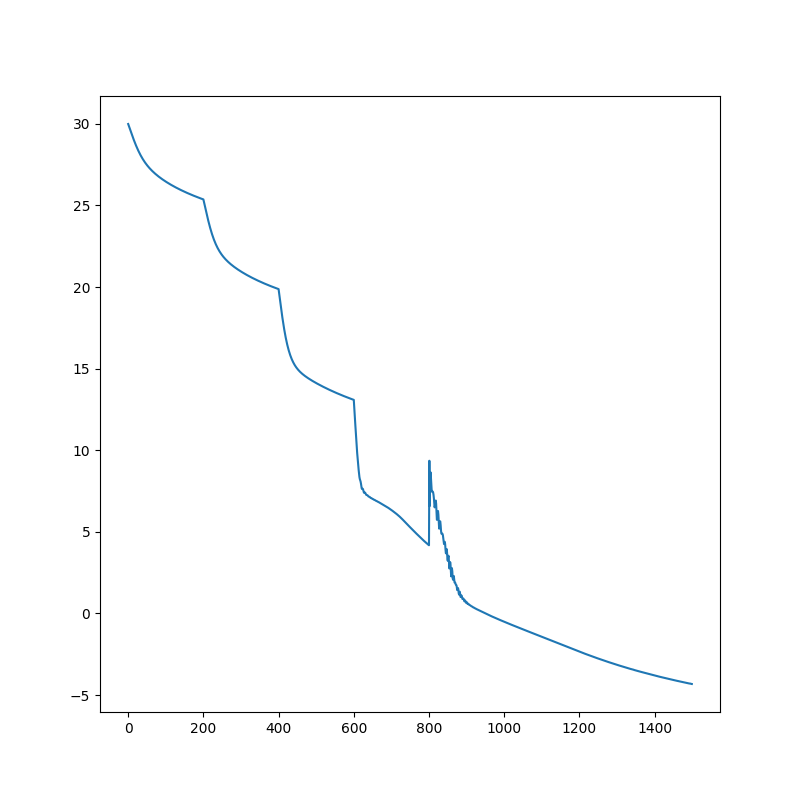

In [197]:
#all_steps = np.linspace(1,len(history),len(history))
plt.figure(figsize=(8,8))
plt.plot(np.log(historyHiggs_3d_scrambled))
plt.show()

In [198]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(VHiggs_3d_scrambled,xHiggs_3d_scrambled)**2,axis=1).numpy()>10**(-i))}")
          

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 27
Number of points with ||∇V||^2 > 1e-05 : 144
Number of points with ||∇V||^2 > 1e-06 : 516
Number of points with ||∇V||^2 > 1e-07 : 921
Number of points with ||∇V||^2 > 1e-08 : 1353
Number of points with ||∇V||^2 > 1e-09 : 2071
Number of points with ||∇V||^2 > 1e-10 : 2777
Number of points with ||∇V||^2 > 1e-11 : 5305
Number of points with ||∇V||^2 > 1e-12 : 14198
Number of points with ||∇V||^2 > 1e-13 : 26632
Number of points with ||∇V||^2 > 1e-14 : 38427


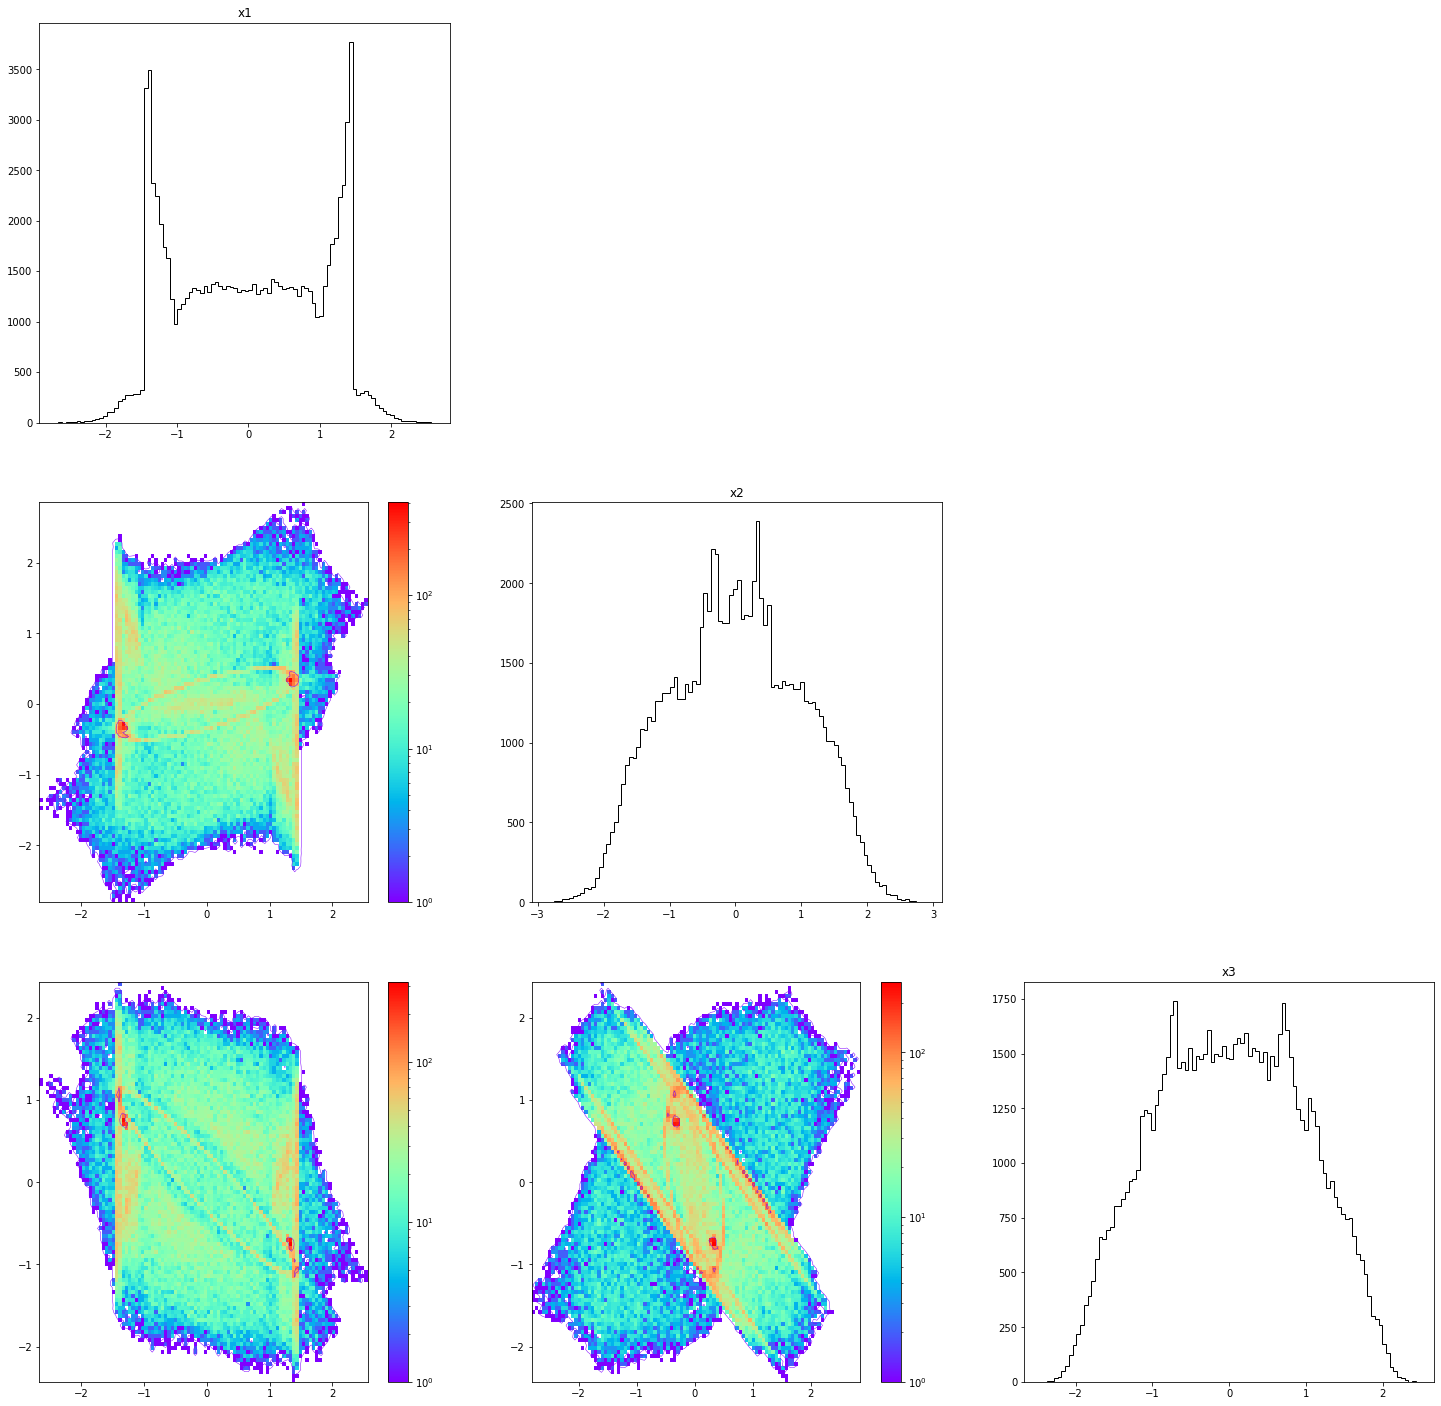

In [102]:
triangular_plot(xHiggs_3d_scrambled)

In [207]:
# Create the autoencoder 
input_dim = 3 
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation='sigmoid')(inputs)
#encoded = layers.Dense(8, activation='sigmoid')(encoded)
#encoded = layers.Dense(16, activation='relu')(encoded)
#encoded = layers.Dense(8, activation='relu')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
#decoded = layers.Dense(8, activation='sigmoid')(decoded)
#decoded = layers.Dense(16, activation='relu')(decoded)
#decoded = layers.Dense(8, activation='relu')(decoded)
decoded = layers.Dense(input_dim)(decoded) 

# Modèle auto-encodeur
autoencoder_deep_scrambled = keras.Model(inputs, decoded)
autoencoder_deep_scrambled.compile(optimizer='adam', loss='mse')

In [208]:
autoencoder_deep_scrambled.summary()

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

In [209]:
history_autoencoder_Higgs_scrambled = autoencoder_deep_scrambled.fit(xHiggs_3d_sc_sorted, xHiggs_3d_sc_sorted, epochs=50, batch_size=100, shuffle=True)


Epoch 1/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8052
Epoch 2/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1038
Epoch 3/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0640
Epoch 4/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0507
Epoch 5/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0413
Epoch 6/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0220
Epoch 7/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0054
Epoch 8/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0041
Epoch 9/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032
Epoch 10/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027
Epoch 11/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022
Epoch 12/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019
Epoch 13/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016
Epoch 14/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014
Epoch 15/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

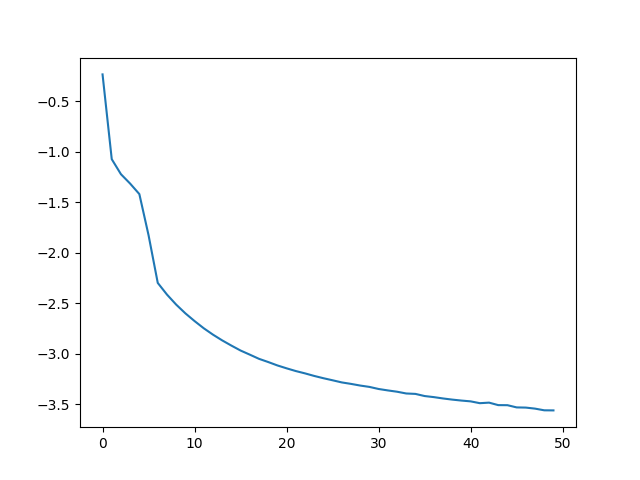

In [210]:
plt.figure()
plt.plot(np.log(history_autoencoder_Higgs_scrambled.history["loss"])/np.log(10))
plt.show()

In [211]:
reconstructed_points_deep_sc = autoencoder_deep_scrambled.predict(xHiggs_3d_sc_sorted)  


1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step


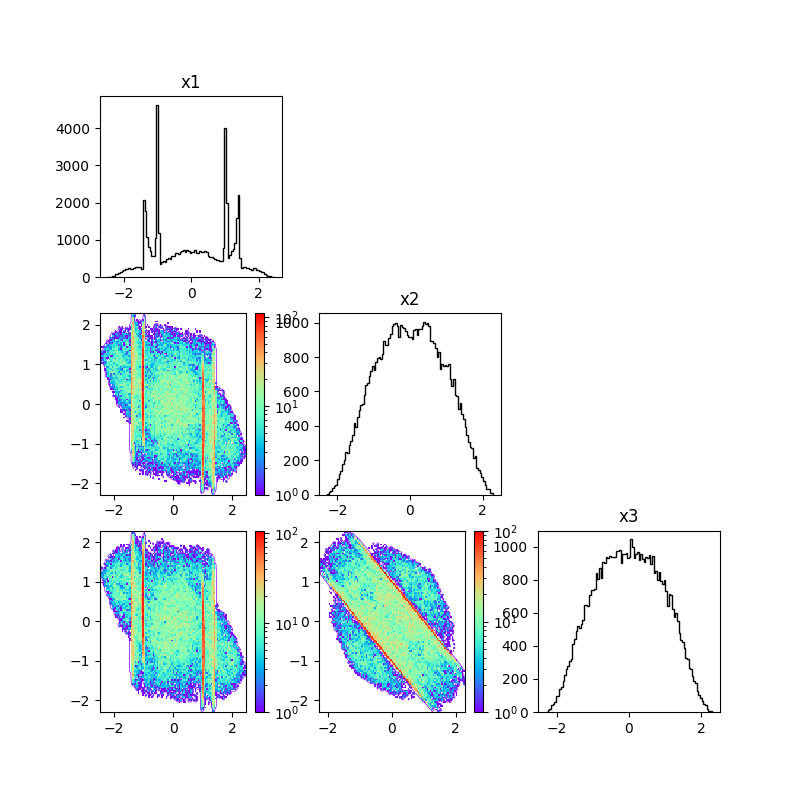

In [212]:
triangular_plot(reconstructed_points_deep_sc,fig_size=8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_2334/565528221.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


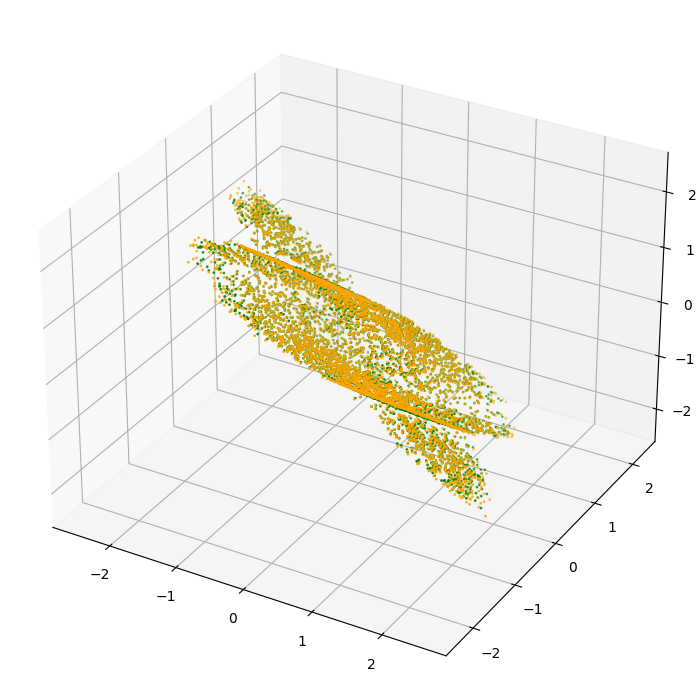

In [213]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(reconstructed_points_deep_sc[::10,0],reconstructed_points_deep_sc[::10,1],reconstructed_points_deep_sc[::10,2],color="green",s=1) 
ax.scatter(xHiggs_3d_sc_sorted[::10,0],xHiggs_3d_sc_sorted[::10,1],xHiggs_3d_sc_sorted[::10,2],color="orange",s=1) 

plt.show()


In [560]:
# So with 3 nodes in the middle, it is possible to reconstruct the points

In [559]:
# If we try to do 1 or 2 nodes in the middle, this will fail
# Try first to extract 1d lines

In [214]:
mask_train = np.array([np.random.rand()<0.9 for i in range(100000)])
set_train = np.array([np.extract(mask_train,xHiggs_3d_scrambled.numpy()[:,i]) for i in range(3)]).T
set_test = np.array([np.extract(1-mask_train,xHiggs_3d_scrambled.numpy()[:,i]) for i in range(3)]).T
print(set_train.shape)
print(set_test.shape)

(89957, 3)
(10043, 3)


In [338]:
# Create the autoencoder 
input_dim = 3 
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(inputs)
encoded = layers.Dense(64, activation='relu')(encoded)
#encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
#decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim)(decoded) 

# Modèle auto-encodeur
autoencoder_deep_scrambled_2 = keras.Model(inputs, decoded)
autoencoder_deep_scrambled_2.compile(optimizer='adam', loss='mse')

# Fairly large. Smaller also seem to work, but not as good. Should play more with it. 

In [340]:
autoencoder_deep_scrambled_2.summary()

Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,093 (35.52 KB)

 Trainable params: 9,093 (35.52 KB)

 Non-trainable params: 0 (0.00 B)

In [341]:
history_autoencoder_Higgs_scrambled_2 = autoencoder_deep_scrambled_2.fit(set_train, set_train
                                    , epochs=200
                                    , batch_size=100
                                    , shuffle=True
                                    , validation_data = (set_test,set_test))


Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1533 - val_loss: 0.0231
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0210 - val_loss: 0.0175
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0161 - val_loss: 0.0134
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127 - val_loss: 0.0107
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0109
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0099 - val_loss: 0.0090
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 8/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 9/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0116 - val_loss: 0.0057
Epoch 10/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0051 - val_loss: 0.0085
Epoch 11/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 12/200
900/900 ━━━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(history_autoencoder_Higgs_scrambled_2.history["loss"])
plt.plot(history_autoencoder_Higgs_scrambled_2.history["val_loss"])
plt.show()

In [342]:
reconstructed_points_deep_sc_2 = autoencoder_deep_scrambled_2.predict(xHiggs_3d_scrambled.numpy())  


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 846us/step


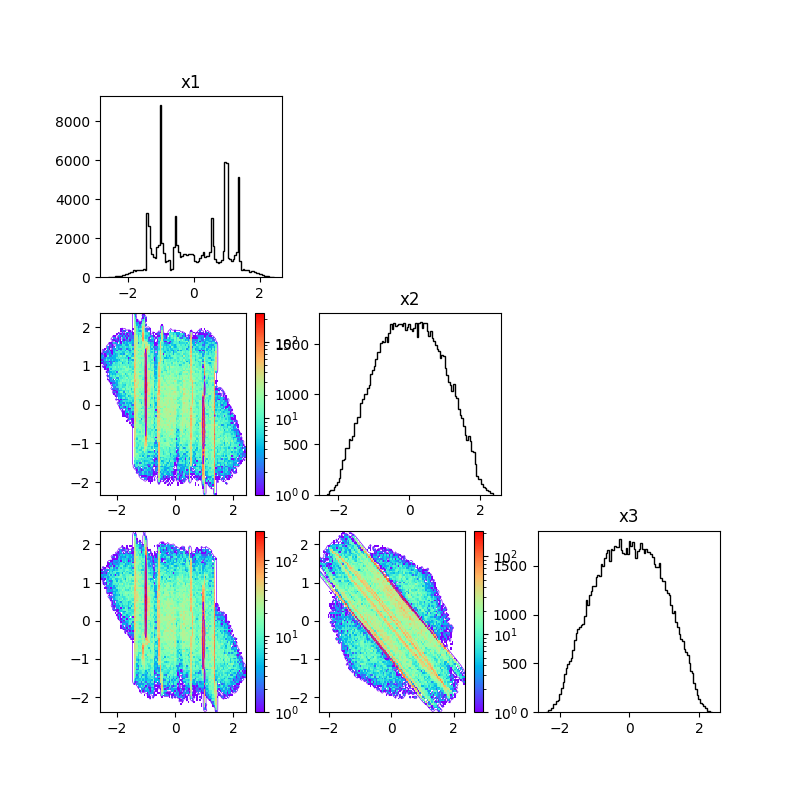

In [343]:
triangular_plot(reconstructed_points_deep_sc_2,fig_size=8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_2334/825714060.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


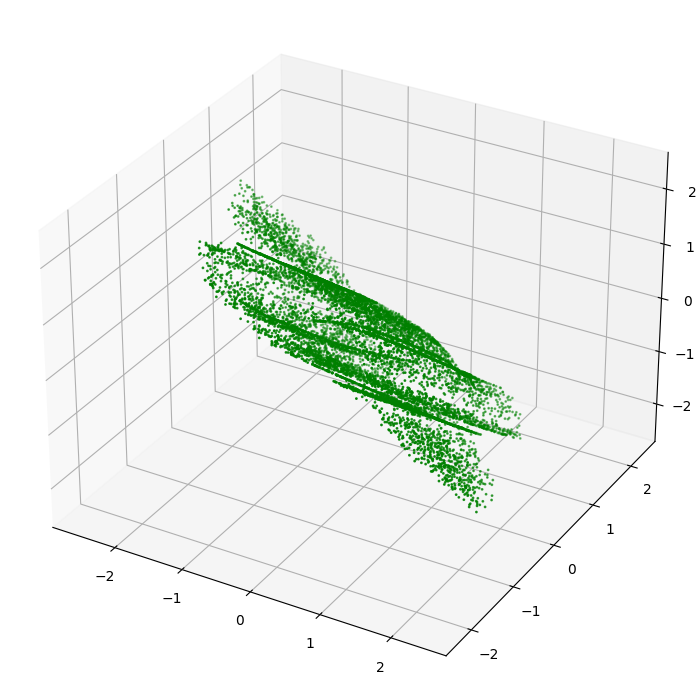

In [344]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(reconstructed_points_deep_sc_2[::10,0],reconstructed_points_deep_sc_2[::10,1],reconstructed_points_deep_sc_2[::10,2],color="green",s=1) 
#ax.scatter(xHiggs_3d_sc_sorted[::10,0],xHiggs_3d_sc_sorted[::10,1],xHiggs_3d_sc_sorted[::10,2],color="orange",s=1) 

plt.show()


In [358]:
encoder_Higgs_sc_2 = models.Model(inputs, encoded)

latent_inputs = layers.Input(shape=(latent_dim,))  
decoded_layer = autoencoder_deep_scrambled_2.layers[-3](latent_inputs)
decoded_layer = autoencoder_deep_scrambled_2.layers[-2](decoded_layer)
decoded_output = autoencoder_deep_scrambled_2.layers[-1](decoded_layer)

#decoder_Higgs_sc_2 = models.Model(latent_inputs,decoded)

decoder_Higgs_sc_2 = models.Model(latent_inputs, decoded_output)

In [363]:
encoded_points_Higgs_sc_2 = encoder_Higgs_sc_2.predict(set_test)

314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


In [364]:
decoded_points_Higgs_sc_2 = decoder_Higgs_sc_2.predict(encoded_points_Higgs_sc)

314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_2334/2901190443.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


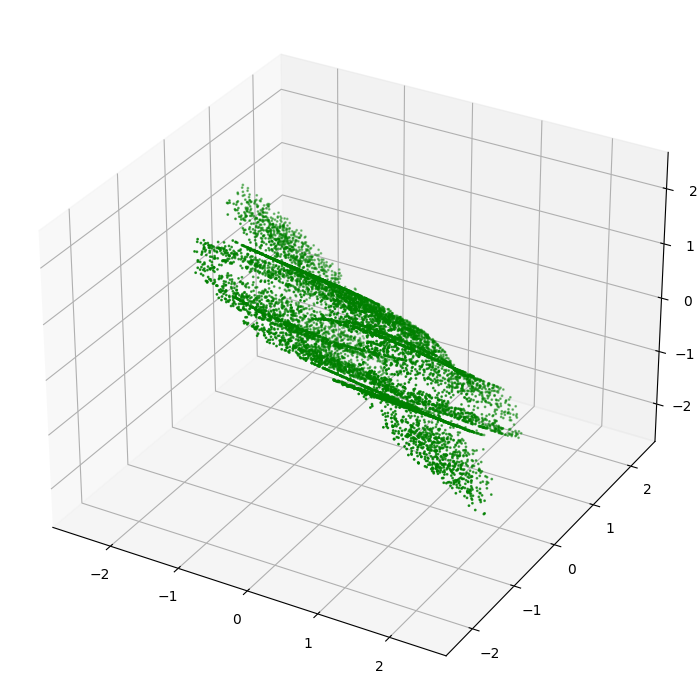

In [361]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(decoded_points_Higgs_sc[:,0],decoded_points_Higgs_sc[:,1],decoded_points_Higgs_sc[:,2],color="green",s=1) 
#ax.scatter(xHiggs_3d_sc_sorted[::10,0],xHiggs_3d_sc_sorted[::10,1],xHiggs_3d_sc_sorted[::10,2],color="orange",s=1) 

plt.show()


In [ ]:
#####

In [365]:
encoded_points_Higgs_sc_2.shape

(10043, 2)

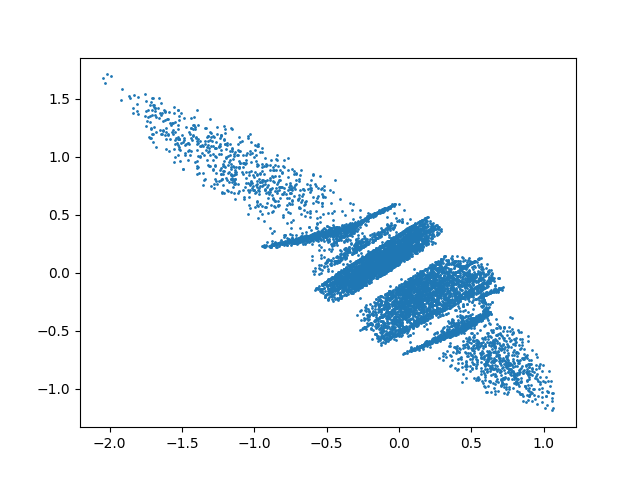

In [366]:
plt.figure()
plt.scatter(encoded_points_Higgs_sc_2[:,0],encoded_points_Higgs_sc_2[:,1],s=1)
plt.show()

In [ ]:
# Seems to show a linear constraint between two coordinates 

In [ ]:
#####

In [308]:
n_points_excite = 10000
excite_y0_raw = np.linspace(-2.5076113,2.5358918,n_points_excite)
excite_y0 = np.zeros((n_points_excite,2))
excite_y0[:,0] += excite_y0_raw

excite_y1_raw = np.linspace(-3,3,n_points_excite)
excite_y1 = np.zeros((n_points_excite,2))
excite_y1[:,1] += excite_y1_raw

In [309]:
decoded_points_y0 = decoder_Higgs_sc.predict(excite_y0)
decoded_points_y1 = decoder_Higgs_sc.predict(excite_y1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


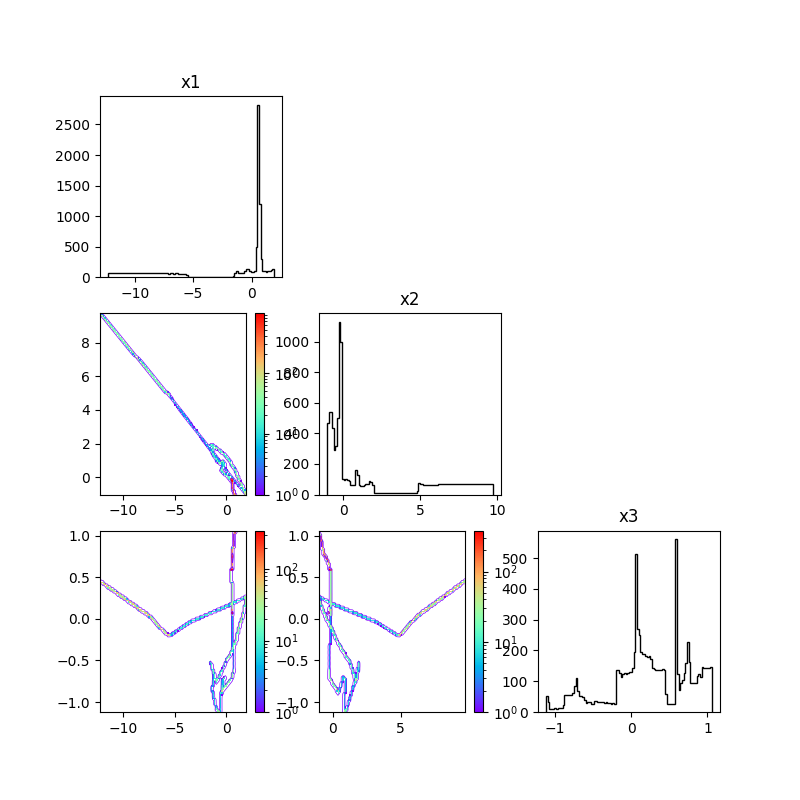

In [313]:
triangular_plot(decoded_points_y0,fig_size=8)


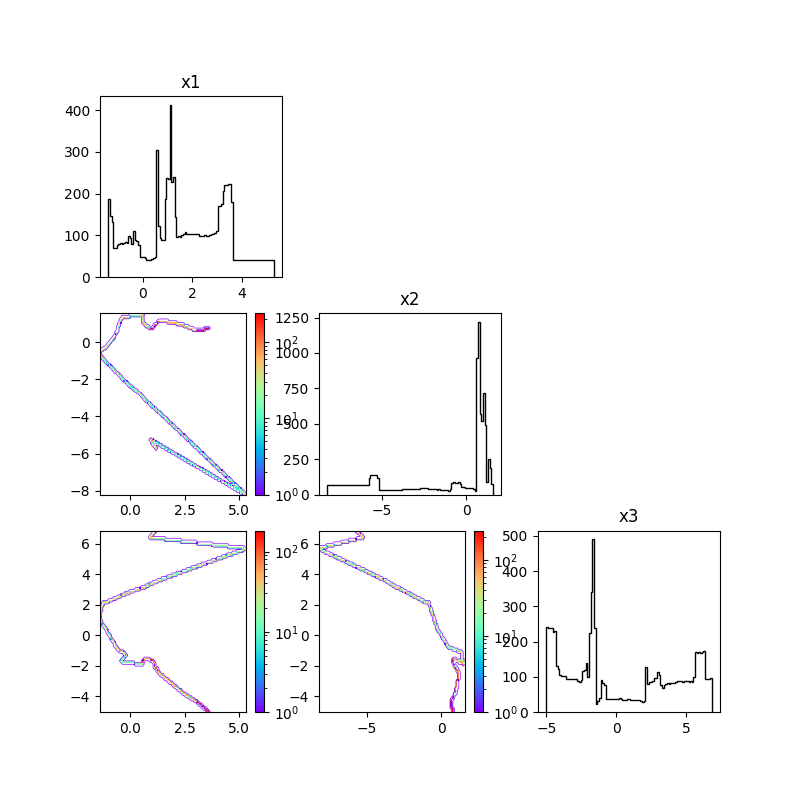

In [314]:
triangular_plot(decoded_points_y1,fig_size=8)

In [315]:
decoded_points_rand = decoded_points_y1 = decoder_Higgs_sc.predict(np.random.rand(10000,2)*2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


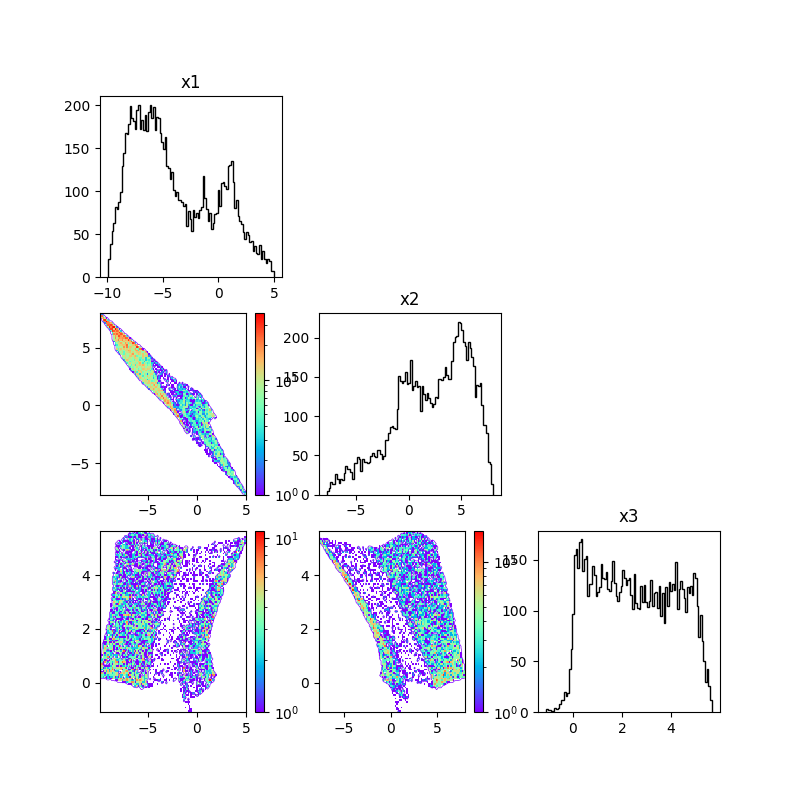

In [316]:
triangular_plot(decoded_points_rand,fig_size=8)

/var/folders/7f/2871v4nx3pn_dph55xj6sxq40000gn/T/ipykernel_2334/1426739066.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


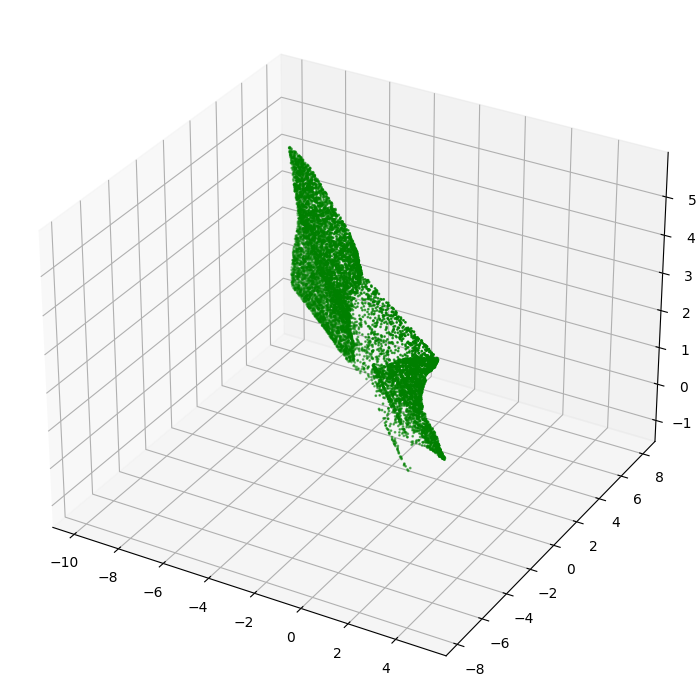

In [317]:
fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig) 

ax.scatter(decoded_points_rand[:,0],decoded_points_rand[:,1],decoded_points_rand[:,2],color="green",s=1) 
#ax.scatter(xHiggs_3d_sc_sorted[::10,0],xHiggs_3d_sc_sorted[::10,1],xHiggs_3d_sc_sorted[::10,2],color="orange",s=1) 

plt.show()


In [326]:
# 1d autoencoder 

# Create the autoencoder 
input_dim = 3 
latent_dim = 1

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded_1 = layers.Dense(64, activation='relu')(inputs)
encoded_1 = layers.Dense(64, activation='relu')(encoded_1)
encoded_1 = layers.Dense(latent_dim)(encoded_1)  

# Decoder
decoded_1 = layers.Dense(64, activation='relu')(encoded_1)
decoded_1 = layers.Dense(64, activation='relu')(decoded_1)
decoded_1 = layers.Dense(input_dim)(decoded_1) 

# Modèle auto-encodeur
autoencoder_deep_scrambled_1 = keras.Model(inputs, decoded_1)
autoencoder_deep_scrambled_1.compile(optimizer='adam', loss='mse')

In [327]:
history_autoencoder_Higgs_scrambled_1 = autoencoder_deep_scrambled_1.fit(set_train, set_train
                                    , epochs=100
                                    , batch_size=100
                                    , shuffle=True
                                    , validation_data = (set_test,set_test))


Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4006 - val_loss: 0.1680
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1645 - val_loss: 0.1549
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1508 - val_loss: 0.1391
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1373 - val_loss: 0.1276
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1353 - val_loss: 0.1548
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1491 - val_loss: 0.1415
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1365 - val_loss: 0.1222
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1247 - val_loss: 0.1158
Epoch 9/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1168 - val_loss: 0.1116
Epoch 10/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1103 - val_loss: 0.1053
Epoch 11/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1081 - val_loss: 0.1085
Epoch 12/100
900/900 ━━━━━━━━━━━━━━━━━━━━

In [328]:
encoder_Higgs_sc_1 = models.Model(inputs, encoded_1)

latent_inputs = layers.Input(shape=(latent_dim,))  
decoded_layer_1 = autoencoder_deep_scrambled_1.layers[-3](latent_inputs)
decoded_layer_1 = autoencoder_deep_scrambled_1.layers[-2](decoded_layer_1)
decoded_output_1 = autoencoder_deep_scrambled_1.layers[-1](decoded_layer_1)

decoder_Higgs_sc_1 = models.Model(latent_inputs, decoded_output_1)

In [ ]:
triangular_plot(decoder_Higgs_sc_1,fig_size=8)
